# Step 1) Image Acquisition

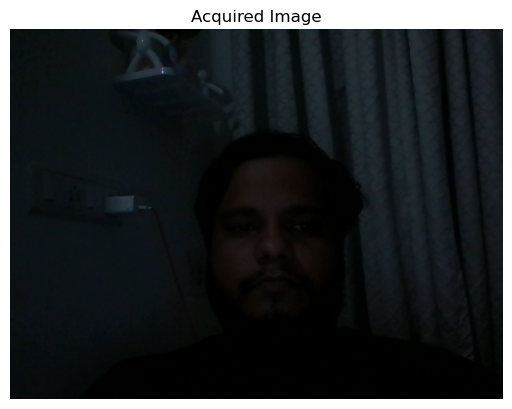

In [1]:
import cv2
import matplotlib.pyplot as plt

# Acquire from webcam
cap = cv2.VideoCapture(0)  # 0 = default camera
ret, frame = cap.read()

if ret:
    # Save image
    cv2.imwrite('acquired_image.jpg', frame)

    # Convert BGR (OpenCV) to RGB (Matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Show using matplotlib
    plt.imshow(frame_rgb)
    plt.title("Acquired Image")
    plt.axis("off")
    plt.show()

cap.release()

# Step 2) Preprocessing

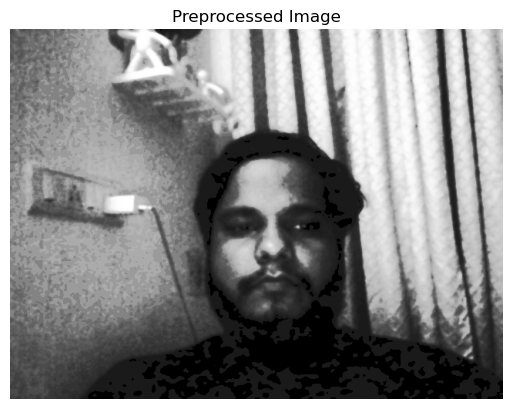

In [2]:
import cv2
import matplotlib.pyplot as plt

# Read image
img = cv2.imread('acquired_image.jpg')

# Preprocessing steps
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # Grayscale
blur = cv2.GaussianBlur(gray, (5, 5), 0)       # Denoise
equalized = cv2.equalizeHist(blur)             # Contrast enhancement

# Save output
cv2.imwrite('preprocessed.jpg', equalized)

# Display using matplotlib (grayscale)
plt.imshow(equalized, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

# Step 3 Region of interest and segmentation

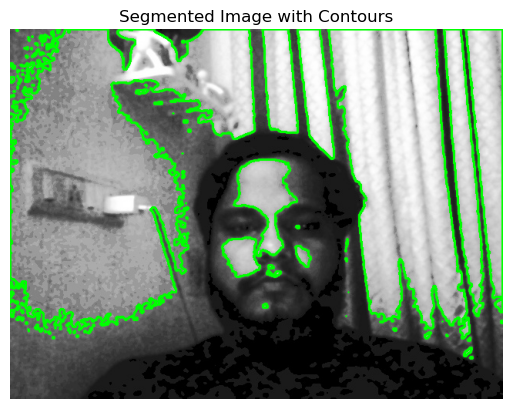

In [3]:
import cv2
import matplotlib.pyplot as plt

# Read preprocessed image in grayscale
img = cv2.imread('preprocessed.jpg', 0)

# Binary segmentation
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Convert grayscale to BGR for colored contours
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw contours (green)
cv2.drawContours(output, contours, -1, (0, 255, 0), 2)

# Save output
cv2.imwrite('segmented.jpg', output)

# Convert BGR → RGB for matplotlib
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.imshow(output_rgb)
plt.title("Segmented Image with Contours")
plt.axis("off")
plt.show()

# Step 4) Feature Extraction

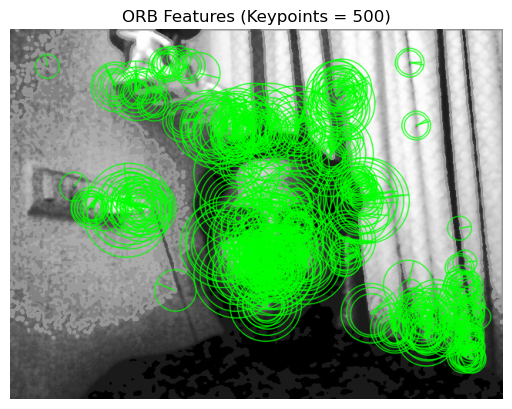

In [4]:
import cv2
import matplotlib.pyplot as plt

# Read image (grayscale)
img = cv2.imread('segmented.jpg', 0)

# ORB feature detector
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img, None)

# Draw keypoints (green)
output = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Convert BGR → RGB for matplotlib
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.imshow(output_rgb)
plt.title(f"ORB Features (Keypoints = {len(keypoints)})")
plt.axis("off")
plt.show()

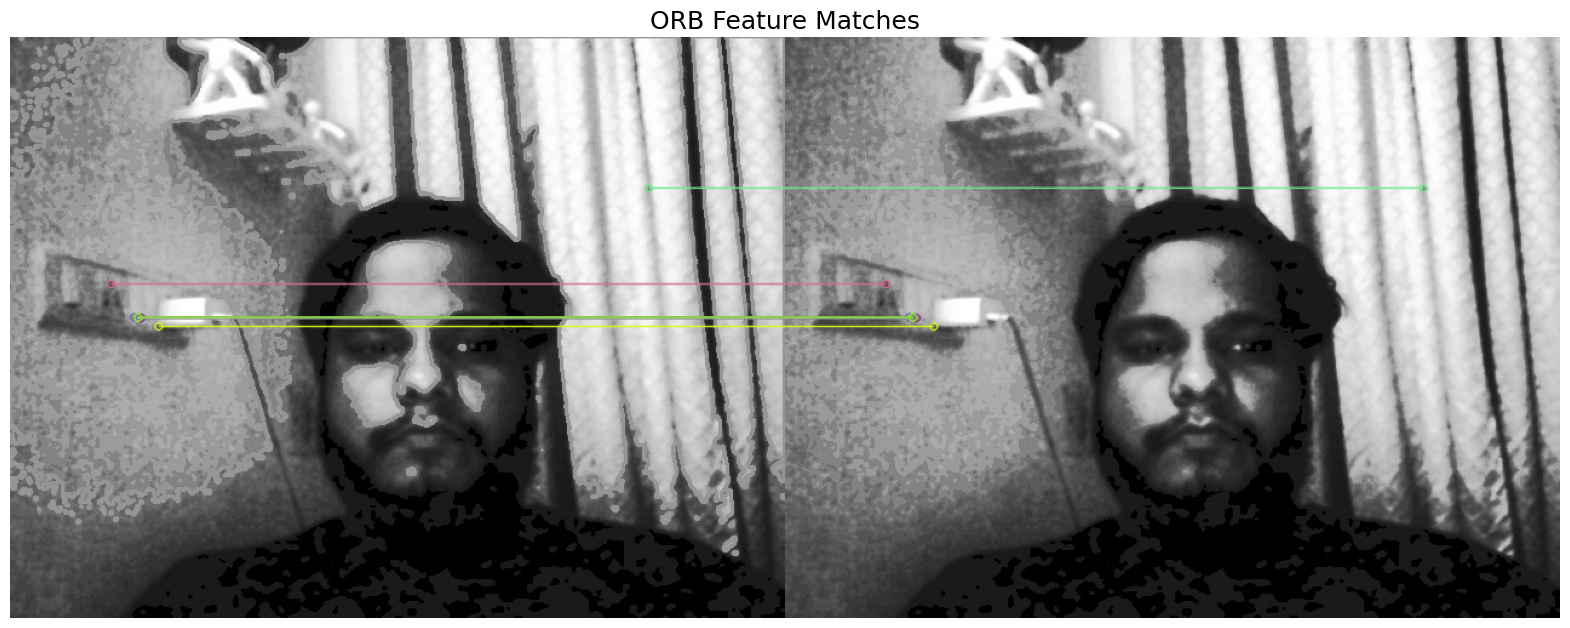

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read images
img1 = cv2.imread('segmented.jpg', 0)
img2 = cv2.imread('preprocessed.jpg', 0)

# ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
output = cv2.drawMatches(
    img1, kp1,
    img2, kp2,
    matches[:10],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Convert BGR → RGB
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 10))   # width, height in inches
plt.imshow(output_rgb)
plt.title("ORB Feature Matches", fontsize=18)
plt.axis("off")
plt.show()

In [6]:
import cv2

img = cv2.imread('segmented.jpg', 0)
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for cnt in contours:
    area = cv2.contourArea(cnt)
    label = "Large" if area > 1000 else "Small"  # Simple classification
    cv2.drawContours(output, [cnt], 0, (0,255,0), 2)
    cv2.putText(output, label, (cnt[0][0][0], cnt[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
cv2.imshow('Classified', output)
cv2.waitKey(0)
cv2.destroyAllWindows()

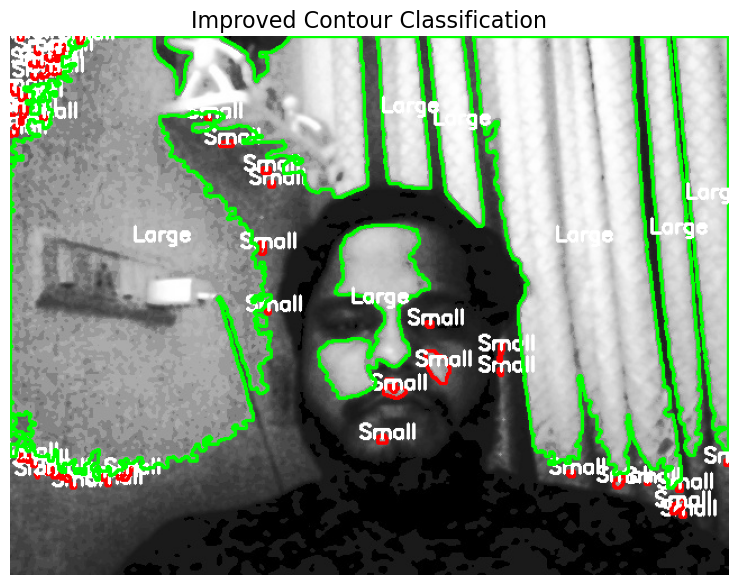

In [7]:
import cv2
import matplotlib.pyplot as plt

# -------------------------------
# 1. Read image (grayscale)
# -------------------------------
img = cv2.imread('segmented.jpg', cv2.IMREAD_GRAYSCALE)

# Safety check
if img is None:
    raise ValueError("Image not found or unable to read")

# -------------------------------
# 2. Binary thresholding (BEST PRACTICE)
# -------------------------------
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# -------------------------------
# 3. Find contours
# -------------------------------
contours, _ = cv2.findContours(
    binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Convert to BGR for colored drawing
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# -------------------------------
# 4. Dynamic area threshold
# -------------------------------
image_area = img.shape[0] * img.shape[1]
area_threshold = 0.005 * image_area   # 0.5% of image area

# -------------------------------
# 5. Contour classification
# -------------------------------
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 10:   # Ignore noise
        continue

    label = "Large" if area > area_threshold else "Small"
    color = (0, 255, 0) if label == "Large" else (0, 0, 255)

    # Draw contour
    cv2.drawContours(output, [cnt], -1, color, 2)

    # Centroid for better text placement
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = cnt[0][0]

    # Put label
    cv2.putText(
        output,
        label,
        (cx - 20, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (255, 255, 255),
        2
    )

# -------------------------------
# 6. Display using matplotlib
# -------------------------------
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 7))
plt.imshow(output_rgb)
plt.title("Improved Contour Classification", fontsize=16)
plt.axis("off")
plt.show()